In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import pathlib, os, shutil
import random
import requests
import warnings

from zipfile import ZipFile
from PIL import Image

from csv import reader

warnings.filterwarnings('ignore')

In [2]:
pathToDataset = pathlib.Path.cwd().joinpath('..', 'Ml-Project2\Dataset')
os.chdir(pathToDataset)

images_file = os.path.join(pathToDataset, 'downloads.zip')

# Extracting all the images to `train` folder
with ZipFile(images_file, 'r') as zipObj:
   zipObj.extractall(pathToDataset)

In [3]:
def getFilesInDirectory(pathToDir, extension = "*.*"):
    if not isinstance(pathToDir, pathlib.PurePath):
        pathToDir = pathlib.Path(pathToDir)

    return list(pathToDir.glob(extension))

# Retrieves the list of folders with a directory
def getFolderNamesInDirectory(pathToDir, prefix = ""):
    if not isinstance(pathToDir, pathlib.PurePath):
        pathToDir = pathlib.Path(pathToDir)

    return sorted([fld.name for fld in pathToDir.iterdir() if fld.is_dir() and not fld.name.lower().startswith(prefix)])

In [4]:
pathToDataset  = pathlib.Path.cwd()
pathToDownload = pathToDataset.joinpath('downloads')

pathToTrain = pathToDataset.joinpath('train')
if not pathToTrain.exists():
    pathToTrain.mkdir()

pathToTest = pathToDataset.joinpath('test')
if not pathToTest.exists():
    pathToTest.mkdir()

pathToValid = pathToDataset.joinpath('valid')
if not pathToValid.exists():
    pathToValid.mkdir()

###
# Sets the folder for models (where all the models will be saved)
pathToModels = pathToDataset.joinpath('..', 'models')
if not pathToModels.exists():
    pathToModels.mkdir()

In [5]:
# list the folders required under 'dataset' folder (using a list to reduce the lines of code)
artCategories = getFolderNamesInDirectory(pathToDownload, ".")  #collects the list of folders
print("Total no. of categories = ", len(artCategories))  #displays the number of classes (= Art categories)
print("Categories: ", artCategories)  #displays the list of classes

Total no. of categories =  4
Categories:  ['genre', 'landscape', 'portrait', 'still-life']


In [6]:
for artCategory in artCategories:

    # Sets the source folder
    path_source = pathToDownload.joinpath(artCategory)
    
    # Sets the datasets
    files = getFilesInDirectory(path_source, '*.jpg')    # lists all the 'jpg' images in the folder
    random.shuffle( files )
    split_idx = int(round(len(list(files)) / 5, 0))      # Determines the splitting index: 5 = 20%
    split_images = np.split(files, [3*split_idx, 4*split_idx, 5*split_idx]) # Split the files across the 3 datasets

    # Sets the target folders
    path_target_train = pathToTrain.joinpath(artCategory)
    if not path_target_train.exists():
        path_target_train.mkdir()
    for img_file in split_images[0]:
        shutil.move(img_file, path_target_train.joinpath(img_file.name))    
            
    path_target_test = pathToTest.joinpath(artCategory)
    if not path_target_test.exists():
        path_target_test.mkdir()
    for img_file in split_images[1]:
        shutil.move(img_file, path_target_test.joinpath(img_file.name))    

    path_target_valid = pathToValid.joinpath(artCategory)
    if not path_target_valid.exists():
        path_target_valid.mkdir()
    for img_file in split_images[2]:
        shutil.move(img_file, path_target_valid.joinpath(img_file.name))    

In [7]:
def cleanImages(location):
    artCategories = getFolderNamesInDirectory(location, ".")

    # For each art category
    for artCategory in artCategories:

        # Sets the source folder
        path_source = pathToTrain.joinpath(artCategory)

        # Sets the datasets
        files = getFilesInDirectory(path_source, '*.jpg')    # lists all the 'jpg' images in the folder

        for file in files:
            try:
                img = Image.open(file)
            except IOError:
                print( file )
                os.remove(file)

pathToTrain = pathlib.Path.cwd().joinpath('..', 'dataset', 'train')
cleanImages(pathToTrain)

pathToValid = pathlib.Path.cwd().joinpath('..', 'dataset', 'valid')
cleanImages(pathToValid)

pathToTest = pathlib.Path.cwd().joinpath('..', 'dataset', 'test')
cleanImages(pathToTest)


In [8]:
os.listdir(os.curdir)

['dataset_segmented.zip',
 'downloads',
 'downloads.zip',
 'models',
 'original.zip',
 'segmented',
 'segmented.zip',
 'test',
 'train',
 'urls_cubism.txt',
 'urls_surrealism.txt',
 'valid']

In [9]:
os.getcwd()

'C:\\Users\\Omkar Kadam\\Desktop\\Ml-Projects\\Ml-Project2\\Dataset'

In [10]:
# Common modules/packages
import matplotlib.pyplot as plt
import math
import numpy as np
import pathlib
import sys, shutil, time
import warnings

# PyTorch modules/packages
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision

from torchvision import datasets, models, transforms
from PIL import ImageFile

%matplotlib inline
warnings.filterwarnings('ignore')

In [11]:
device = 'cpu'  # sets the default value
train_on_gpu = torch.cuda.is_available()  # returns True if CUDA enabled GPU is available

if train_on_gpu == True :
    print('CUDA is available!  Training on GPU ...')
    print('\n')
    print(torch.cuda.get_device_properties(0))
    device = 'cuda'    

CUDA is available!  Training on GPU ...


_CudaDeviceProperties(name='NVIDIA GeForce GTX 1650', major=7, minor=5, total_memory=4096MB, multi_processor_count=16)


In [12]:
# Retrieves the list of files with a directory
def getFilesInDirectory(pathToDir, extension = "*.*"):
    if not isinstance(pathToDir, pathlib.PurePath):
        pathToDir = pathlib.Path(pathToDir)

    return list(pathToDir.glob(extension))

# Retrieves the list of folders with a directory
def getFoldersInDirectory(pathToDir, prefix = ""):
    if not isinstance(pathToDir, pathlib.PurePath):
        pathToDir = pathlib.Path(pathToDir)

    return sorted([fld for fld in pathToDir.iterdir() if fld.is_dir() and not fld.name.lower().startswith(prefix)])

# Retrieves the list of folders with a directory
def getFolderNamesInDirectory(pathToDir, prefix = ""):
    if not isinstance(pathToDir, pathlib.PurePath):
        pathToDir = pathlib.Path(pathToDir)

    return sorted([fld.name for fld in pathToDir.iterdir() if fld.is_dir() and not fld.name.lower().startswith(prefix)])

In [13]:
# DEFINE DATA DIRECTORIES & LOCATION OF IMAGE-SETS ARCHIVE
# --------------------------------------------------------

# sets the root folder for image sets
pathToDataset = pathlib.Path.cwd().joinpath('..', 'dataset')
pathToTrain = pathToDataset.joinpath('train')
pathToTest = pathToDataset.joinpath('test')
pathToValid = pathToDataset.joinpath('valid')

# list the folders required under 'dataset' folder (using a list to reduce the lines of code)
artCategories = getFolderNamesInDirectory(pathToTrain, ".")  #collects the list of folders
print("Total no. of categories = ", len(artCategories))  #displays the number of classes (= Art categories)
print("Categories: ", artCategories)  #displays the list of classes

Total no. of categories =  4
Categories:  ['genre', 'landscape', 'portrait', 'still-life']


In [14]:
# Define the data-augmentation transforms including normalisations
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                            std=[0.229, 0.224, 0.225])])
                 
test_transforms  = transforms.Compose([transforms.Resize(256),
                                       transforms.CenterCrop(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                            std=[0.229, 0.224, 0.225])])
                 
valid_transforms = transforms.Compose([transforms.Resize(256),
                                       transforms.CenterCrop(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                            std=[0.229, 0.224, 0.225])])

# load and apply above transforms on dataset using ImageFolder
train_dataset = datasets.ImageFolder(pathToTrain, transform=train_transforms)
test_dataset  = datasets.ImageFolder(pathToTest , transform=test_transforms)
valid_dataset = datasets.ImageFolder(pathToValid, transform=valid_transforms)

# Print out data stats
print('Training  images: ', len(train_dataset))
print('Testing   images: ', len(test_dataset))
print('Validation images:', len(valid_dataset))

Training  images:  1898
Testing   images:  1001
Validation images: 976


In [15]:
# Define dataloader parameters
batch_size = 16  # You might want to increase the size to 32. This might raise an exception 
num_workers=0

# Prepare data loaders
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers, shuffle = True)
test_dataloader  = torch.utils.data.DataLoader(test_dataset , batch_size=batch_size, num_workers=num_workers, shuffle = False)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=batch_size, num_workers=num_workers, shuffle = False)

# Print the batches stats
print('Number of  training  batches:', len(train_dataloader))
print('Number of  testing   batches:', len(test_dataloader))
print('Number of validation batches:', len(valid_dataloader))

Number of  training  batches: 119
Number of  testing   batches: 63
Number of validation batches: 61


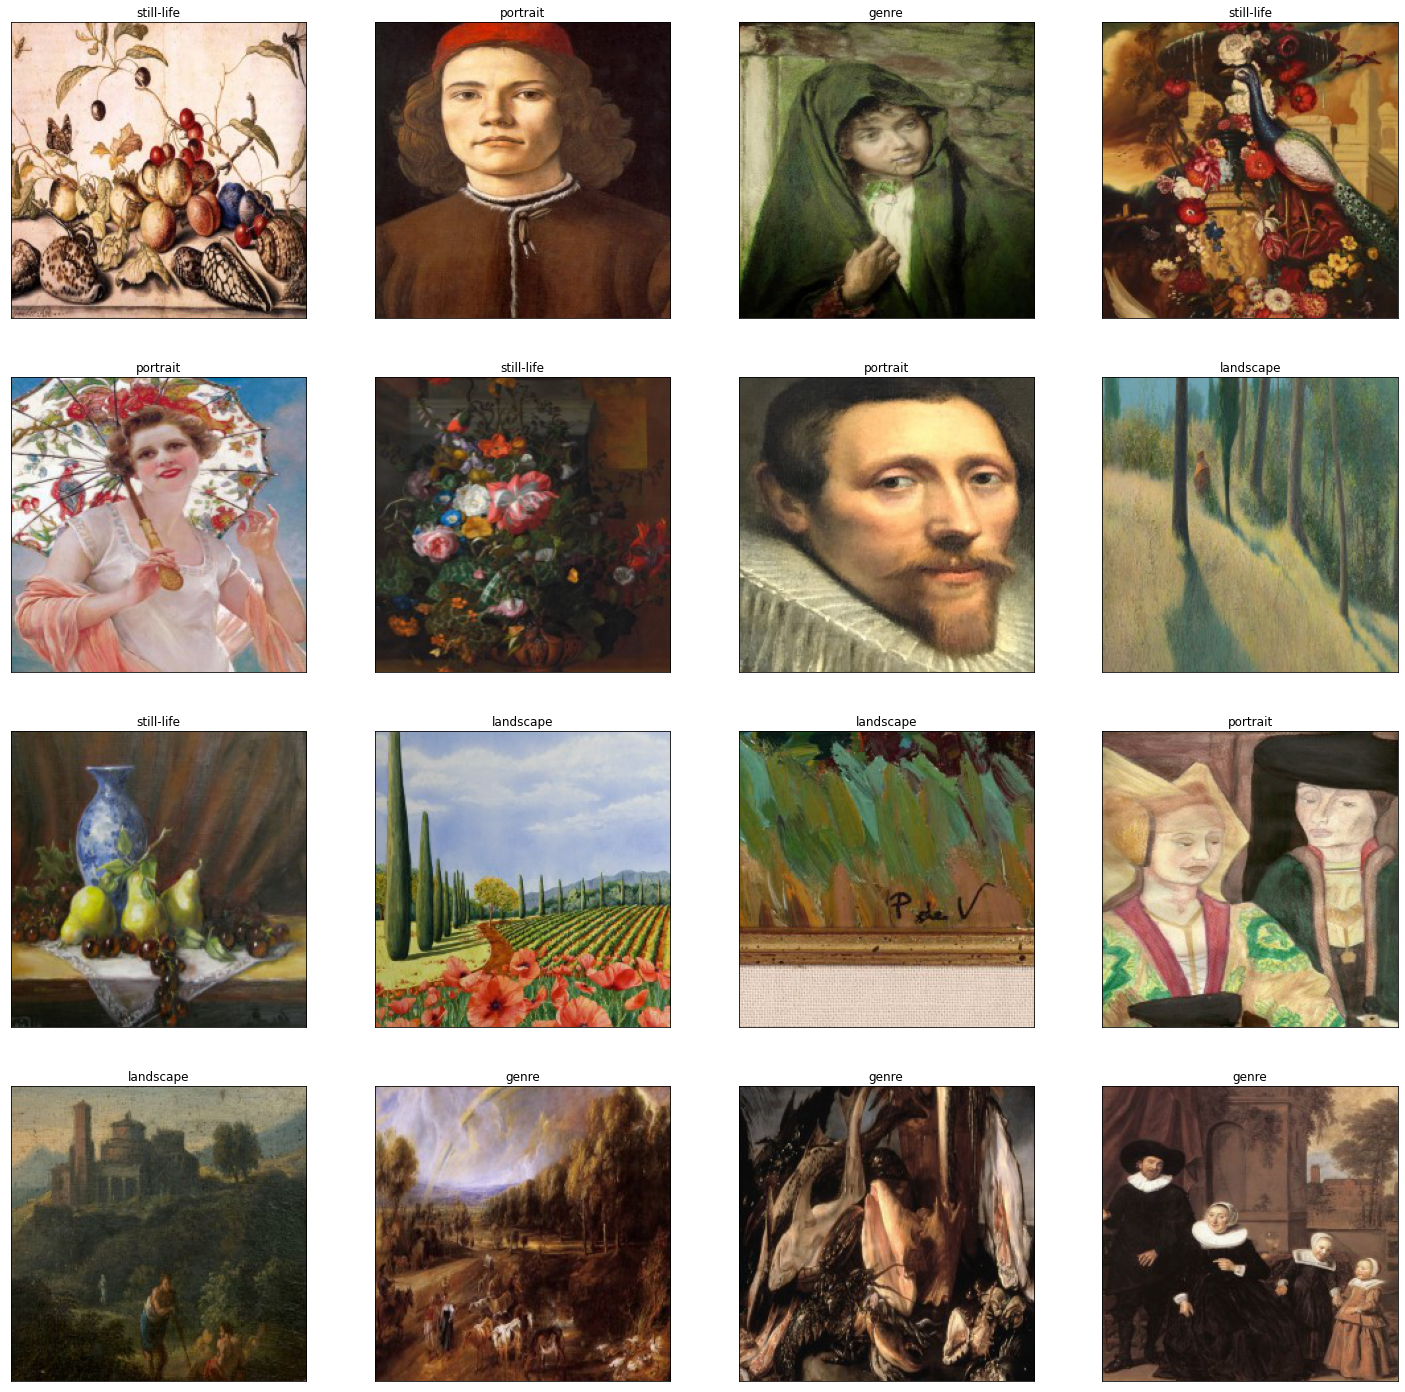

In [16]:
# Ignore normalization and turn shuffle ON to visualize different classes together
visual_transforms = transforms.Compose([transforms.Resize(256),
                                       transforms.CenterCrop(224),
                                       transforms.ToTensor()])

# Load and apply above transforms on dataset using ImageFolder
# Use test directory images can be used for visualization
visual_dataset = datasets.ImageFolder(pathToTest ,transform=visual_transforms)

# Prepare data loaders
visualization_dataloader = torch.utils.data.DataLoader(visual_dataset, batch_size=batch_size, num_workers=num_workers, shuffle=True)

# Obtain one batch of testing images
dataiter = iter(visualization_dataloader)
images, labels = dataiter.next()

# Convert images to numpy for display
images = images.numpy()

# Plot the images in the batch along with the corresponding labels
plotCols = 4
plotRows = math.ceil(batch_size/plotCols) # SqRoot could be used as well: math.ceil(math.sqrt(batch_size))
fig = plt.figure(figsize=(25, 25))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(plotRows, plotCols, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(artCategories[labels[idx]])

In [17]:
from torchvision import models
dir(models)

['AlexNet',
 'DenseNet',
 'GoogLeNet',
 'GoogLeNetOutputs',
 'Inception3',
 'InceptionOutputs',
 'MNASNet',
 'MobileNetV2',
 'MobileNetV3',
 'ResNet',
 'ShuffleNetV2',
 'SqueezeNet',
 'VGG',
 '_GoogLeNetOutputs',
 '_InceptionOutputs',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__path__',
 '__spec__',
 '_utils',
 'alexnet',
 'densenet',
 'densenet121',
 'densenet161',
 'densenet169',
 'densenet201',
 'detection',
 'googlenet',
 'inception',
 'inception_v3',
 'mnasnet',
 'mnasnet0_5',
 'mnasnet0_75',
 'mnasnet1_0',
 'mnasnet1_3',
 'mobilenet',
 'mobilenet_v2',
 'mobilenet_v3_large',
 'mobilenet_v3_small',
 'mobilenetv2',
 'mobilenetv3',
 'quantization',
 'resnet',
 'resnet101',
 'resnet152',
 'resnet18',
 'resnet34',
 'resnet50',
 'resnext101_32x8d',
 'resnext50_32x4d',
 'segmentation',
 'shufflenet_v2_x0_5',
 'shufflenet_v2_x1_0',
 'shufflenet_v2_x1_5',
 'shufflenet_v2_x2_0',
 'shufflenetv2',
 'squeezenet',
 'squeezenet1_0',
 '

In [18]:
import torchvision.models as premod
model_Res= models.resnet50()

print(model_Res)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [19]:
torch.hub._validate_not_a_forked_repo=lambda a,b,c: True

# Select the model to use
model_name = 'resnet50' # alexnet, resnet50, vgg19

# Load the pretrained models from pytorch
model = torch.hub.load('pytorch/vision:v0.6.0', model_name, pretrained=True)

# Print out the model structure
print(model)

Using cache found in C:\Users\Omkar Kadam/.cache\torch\hub\pytorch_vision_v0.6.0


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [20]:
# Freeze training for all "features" layers
if model_name == 'resnet50': # ResNet50 model
    for param in model.parameters():
        param.requires_grad = False
else:
    for param in model.features.parameters():
        param.requires_grad = False

In [21]:
# Input features
from torch import nn
n_inputs = None
last_layer = None

if model_name == 'resnet50': # ResNet50 model
    print(model.fc.in_features) 
    print(model.fc.out_features) 
    n_inputs = model.fc.in_features
    last_layer = nn.Linear(n_inputs, len(artCategories)) #Add last linear layer (n_inputs --to---> n painting classes)
    model.fc = last_layer
else: #AlexNet, Vgg19
    print(model.classifier[6].in_features) 
    print(model.classifier[6].out_features) 
    n_inputs = model.classifier[6].in_features
    last_layer = nn.Linear(n_inputs, len(artCategories)) #Add last linear layer (n_inputs --to---> n painting classes)
    model.classifier[6] = last_layer
    
# if GPU is available, move the model to GPU
if train_on_gpu:
    model=model.to(device)

# Print the new model architecture
print(model)

# Check to see that your last layer produces the expected number of outputs
if model_name == 'resnet50':
    print(model.fc.out_features)
else:
    print(model.classifier[6].out_features)

2048
1000
ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), s

In [22]:
model_filename = 'trained_' + model_name + '.pt'
pathToModel = pathlib.Path.cwd().joinpath('..', 'models', model_filename)
print('File name for saved model: ', pathToModel)

File name for saved model:  C:\Users\Omkar Kadam\Desktop\Ml-Projects\Ml-Project2\Dataset\..\models\trained_resnet50.pt


In [23]:
# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specifying optimizer and learning rate
if model_name == 'resnet50':
    optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
else:
    optimizer = optim.Adam(model.classifier.parameters(), lr=0.001)

In [24]:
# Some images in dataset were truncated (maybe corrupted)
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Set number of epochs to train the model
n_epochs = 40  

# Initialize tracker for minimum validation loss
valid_loss_min = np.Inf # set initial "min" to infinity

# Initialise performances
train_losses, valid_losses, accuracies=[],[],[]
training_loss = 0.0
validation_loss = 0.0
accuracy = 0.0

In [25]:
a = time.time()  # Start-time for training

for epoch in range(1, n_epochs+1):
    c = time.time()  # Start-time for epoch

    ###############
    # TRAIN MODEL #
    ###############
    
    # Getting one batch of training images and their corresponding true labels
    for batch_i, (images, labels) in enumerate(train_dataloader):

        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            images = images.to(device)
            labels = labels.to(device)
            
        # clear the previous/buffer gradients of all optimized variables
        optimizer.zero_grad()
        
        # forward pass: compute predicted outputs by passing inputs to the model
        outputs = model.forward(images)
        
        # calculate the batch loss
        loss = criterion(outputs, labels)    #(y_hat, y)  or (our-prediction, true-label)
        
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        
        # perform a single optimization step (parameter update)
        optimizer.step()
        
        # update training loss 
        training_loss += loss.item()   
        
    ##################
    # VALIDATE MODEL #
    ##################      
    
    # validation loss and accuracy
    validation_loss = 0.0
    accuracy = 0.0

    # model is put to evalution mode i.e. dropout is switched off
    model.eval()

    # turning off calculation of gradients (not required for validaiton)  {saves time}
    with torch.no_grad():

        # getting one batch of validation images
        for images, labels in valid_dataloader: 
            
            # moving data to GPU if available
            if train_on_gpu:
                images = images.to(device)
                labels = labels.to(device)

            outputs = model.forward(images)

            # calculate the batch loss
            batch_loss = criterion(outputs, labels)
            validation_loss += batch_loss.item()
            
            # calculating accuracy - turn raw output values into probabilities using exponential function
            ps = torch.exp(outputs)

            # getting top one probablilty and its corresponding class for batch of images
            top_p, top_class = ps.topk(1, dim=1) 

            #Comparing our predictions to true labels
            equals = top_class == labels.view(*top_class.shape)   #equals is a list of values
            
            #incrementing values of 'accuracy' with equals
            accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            # taking average of equals will give number of true-predictions
            # equals if of ByteTensor (boolean), changing it to FloatTensor for taking mean...
        
    train_losses.append(training_loss/len(train_dataloader))    
    valid_losses.append(validation_loss/len(valid_dataloader))
    accuracies.append(((accuracy/len(valid_dataloader))*100.0))

    # Set epoch end-time
    d = time.time()
    
    print(f"Epoch {epoch} "
          f"Time: {int((d-c)/60)} min {int(d-c)%60} sec "
          f"Train loss: {training_loss/len(train_dataloader):.2f}.. "
          f"Validation loss: {validation_loss/len(valid_dataloader):.2f}.. "
          f"Validation accuracy: {((accuracy/len(valid_dataloader))*100.0):.2f}% "
          )
    
    training_loss = 0.0
    
    # save model if validation loss has decreased
    if ( validation_loss/len(valid_dataloader) <= valid_loss_min):
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min , validation_loss/len(valid_dataloader)))

        # saving model
        torch.save(model.state_dict(), pathToModel)

        # update minimum validation loss
        valid_loss_min = validation_loss/len(valid_dataloader)
    
    # after validation, model is put to training mode i.e. dropout is again switched on
    model.train()
    
    ################
    # END OF EPOCH #
    ################

# end-time for training
b = time.time()  #end-time for training
print('\n\n\tTotal training time: ' , int((b-a)/(60*60)), "hour(s) " , int(((b-a)%(60*60))/60),"minute(s) ", int(((b-a)%(60*60))%60) , "second(s)")

Epoch 1 Time: 0 min 31 sec Train loss: 0.72.. Validation loss: 0.35.. Validation accuracy: 88.32% 
Validation loss decreased (inf --> 0.351007).  Saving model ...
Epoch 2 Time: 0 min 25 sec Train loss: 0.55.. Validation loss: 0.30.. Validation accuracy: 89.75% 
Validation loss decreased (0.351007 --> 0.303530).  Saving model ...
Epoch 3 Time: 0 min 29 sec Train loss: 0.47.. Validation loss: 0.32.. Validation accuracy: 87.81% 
Epoch 4 Time: 0 min 30 sec Train loss: 0.50.. Validation loss: 0.38.. Validation accuracy: 85.66% 
Epoch 5 Time: 0 min 31 sec Train loss: 0.49.. Validation loss: 0.30.. Validation accuracy: 88.63% 
Validation loss decreased (0.303530 --> 0.297896).  Saving model ...
Epoch 6 Time: 0 min 32 sec Train loss: 0.48.. Validation loss: 0.29.. Validation accuracy: 89.65% 
Validation loss decreased (0.297896 --> 0.291817).  Saving model ...
Epoch 7 Time: 0 min 31 sec Train loss: 0.48.. Validation loss: 0.27.. Validation accuracy: 90.06% 
Validation loss decreased (0.291817 

In [26]:
model.load_state_dict(torch.load(pathToModel))

<All keys matched successfully>

In [27]:
test_loss = 0.0
counter = 0

class_correct = list(0. for i in range(len(artCategories)))
class_total = list(0. for i in range(len(artCategories)))
classes_accuracies=[]

# evaluation mode (switching off dropout)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [28]:
y_true = []
y_pred = []

# iterate over test data - get one batch of data from testloader
for images, labels in test_dataloader:
    
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        images = images.to(device)
        labels = labels.to(device)
    
    # compute predicted outputs by passing inputs to the model
    output = model(images)
    
    # calculate the batch loss
    loss = criterion(output, labels)
    
    # update test loss 
    test_loss += loss.item()*images.size(0)
    
    # convert output probabilities to predicted class
    ps, pred = torch.max(output, 1)    
    
    # compare model's predictions to true labels
    for i in range(len(images)):
        y_true.append( artCategories[labels[i]] )
        y_pred.append( artCategories[pred[i]] )

        class_total[labels[i]] += 1
        if pred[i] == labels[i]:
            class_correct[pred[i]] += 1
    counter += 1

# calculate avg test loss
test_loss = test_loss/len(test_dataloader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(len(artCategories)):
    classes_accuracies.append(100 * class_correct[i] / class_total[i])
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            artCategories[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (artCategories[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % 
                          (100. * np.sum(class_correct) / np.sum(class_total),np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.194653

Test Accuracy of genre: 90% (262/289)
Test Accuracy of landscape: 94% (220/232)
Test Accuracy of portrait: 94% (261/277)
Test Accuracy of still-life: 93% (189/203)

Test Accuracy (Overall): 93% (932/1001)


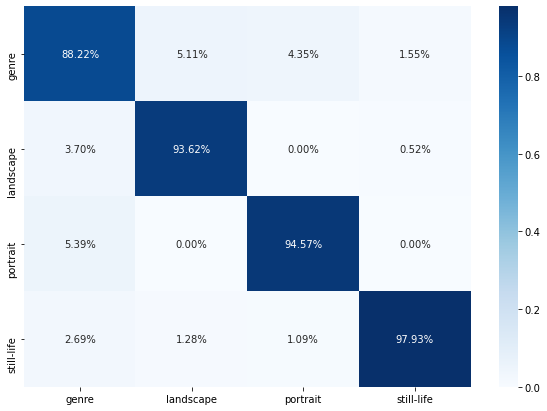

In [29]:
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix

array = confusion_matrix(y_true, y_pred)

df_cm = pd.DataFrame(array, index = [i for i in artCategories],
                  columns = [i for i in artCategories])
plt.figure(figsize = (10,7))
mx = sn.heatmap(df_cm/np.sum(df_cm), annot=True, fmt='.2%', cmap='Blues')
del df_cm

In [30]:
checkpoint = {'training_losses': train_losses,
              'valid_losses': valid_losses,
              'accuracies': accuracies,
              'classes_accuracies':classes_accuracies,
              'state_dict': model.state_dict()}

torch.save(checkpoint, pathToModel)

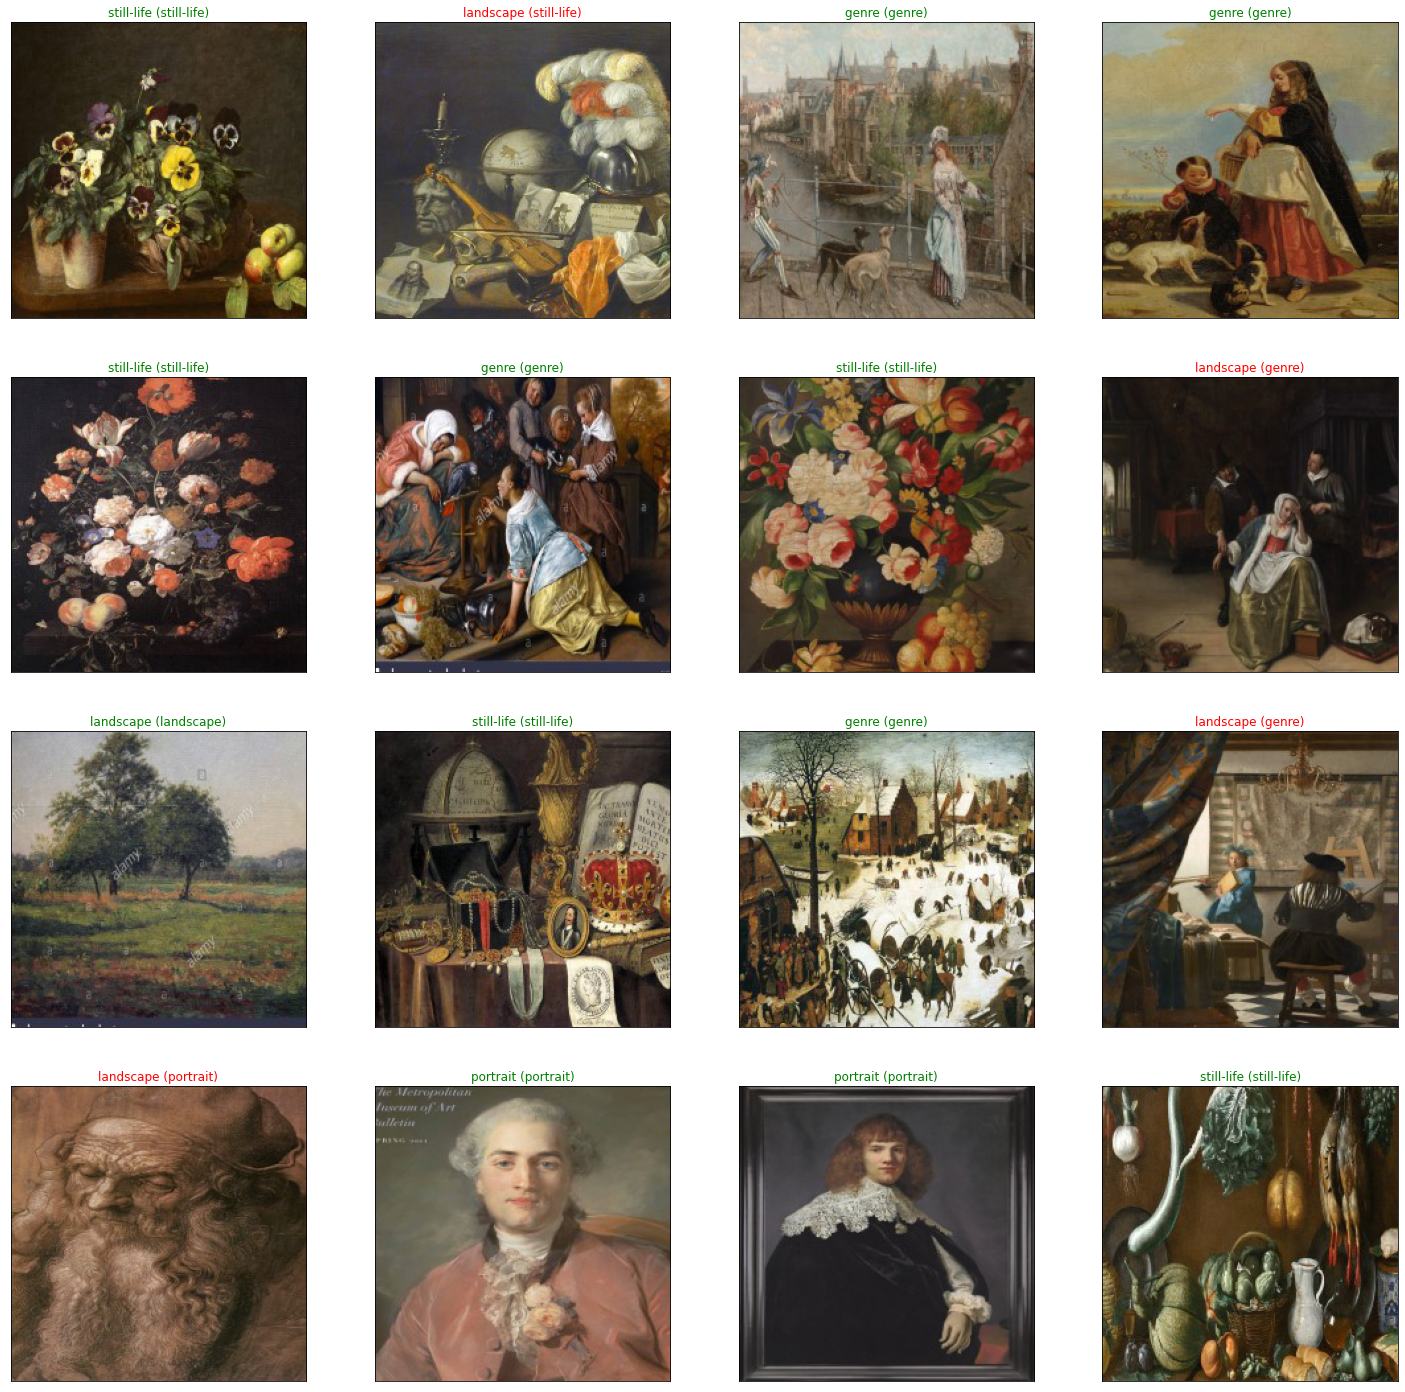

In [31]:
# obtain one batch of test images
dataiter = iter(visualization_dataloader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:    
    images = images.to(device)
    
# get sample outputs
output = model(images)

#move images to CPU for plotting
images = images.cpu()

# convert output probabilities to predicted class
output_ps, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# Plot the images in the batch along with the corresponding labels
plotCols = 4
plotRows = math.ceil(batch_size/plotCols) # SqRoot could be used as well: math.ceil(math.sqrt(batch_size))
fig = plt.figure(figsize=(25, 25))
for idx in np.arange(batch_size):
    ax = fig.add_subplot(plotRows, plotCols, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title("{} ({})".format(artCategories[preds[idx]], artCategories[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))
